In [1]:
import os
import math
import random

import torch
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import pytorch_lightning as pl
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
# fixed settings
target_name = "ICP_pred" 

# hyperparams
args = {}
# training args
args["max_steps"] = 10000
args["val_check_interval"] = 100  # check validation performance every N steps
args["grad_clip_val"] = 1.0
#epochs = 10
args["lr"] = 0.0001
args["bs"] = 8
args["norm_targets"] = False
# data args
args["minutes"] = 5
args["norm_method"] = None # z, None
args["dbs"] = ["MIMIC"]  #"all" # ["eICU", "UKE", "MIMIC"], all
# dataloader args
args["train_noise_std"] = 0.0
args["random_starts"] = False
args["min_len"] = 20
# model args
args["hidden_size"] = 512
# preprocess args
args["fill_type"] = "pat_ema_mask" # "pat_mean", "mean", "pat_ema" "pat_ema_mask"


args["seed"] = 1
seed = pl.utilities.seed.seed_everything(seed=args["seed"], workers=False)

Global seed set to 1


In [3]:
from data import make_split, create_dl

# get args
norm_method = args['norm_method']
norm_targets = args["norm_targets"]
random_starts = args["random_starts"]
bs = args["bs"]
train_noise_std = args["train_noise_std"]
min_len = args["min_len"]
dbs = args["dbs"]
minutes = args["minutes"]

# read df
df_path = f"data/{minutes}_/yeo_N/normalization_{norm_method}/median/uni_clip_0.9999/multi_clip_N/df.pkl"
print("Reading df from: ", df_path)
df = pd.read_pickle(df_path)
if norm_targets:
    df[target_name] = df[target_name] / df[target_name].std()
# turn into seq list
seq_list = [df[df["Pat_ID"] == pat_id].drop(columns=["Pat_ID"]) for pat_id in sorted(df["Pat_ID"].unique())]

# do train/val split
train_data, val_data, train_idcs, val_idcs = make_split(seq_list, test_size=0.2)
# create train dataset
train_dl = create_dl(train_data, train=True, target_name=target_name, random_starts=random_starts, min_len=min_len, bs=bs, 
                     train_noise_std=train_noise_std, dbs=dbs)
val_dl = create_dl(val_data, train=False, target_name=target_name, bs=bs, dbs=dbs)

num_features = train_dl.dataset.inputs[0].shape[-1]
feature_names = train_dl.dataset.feature_names
print(feature_names)

Reading df from:  data/5_/yeo_N/normalization_None/median/uni_clip_0.9999/multi_clip_N/df.pkl
Mean len:  581.924193548387
Mean target:  12.700467841964711
['Med_Narkotikum', 'Med_Opioid', 'Med_Katecholamin', 'Med_Benzodiazepin', 'Med_Barbiturat', 'Vital_diast', 'Vital_GCS_total', 'Vital_mittl', 'Vital_Temp', 'Vital_diast_NBD', 'Vital_syst_NBD', 'Vital_Ppeak', 'Vital_GCS_auge', 'Vital_GCS_motor', 'Vital_GCS_verbal', 'Vital_Pmean', 'Vital_Freq_spontan', 'Vital_Pupille_li', 'Vital_Pupille_re', 'Geschlecht', 'Alter', 'Größe', 'Gewicht', 'Diagnose_MISC', 'Diagnose_TBI']


In [4]:
(~train_data[3]["ICP_pred"].isna()).sum()

618

In [5]:
mean_train_target = np.mean([pd.Series(pat).mean() for pat in train_dl.dataset.targets])
print("Mean train target: ", mean_train_target)

total_icps = np.sum([(~pd.Series(pat).isna()).sum() for pat in train_dl.dataset.targets])
total_steps = np.sum([len(pat) for pat in train_dl.dataset.targets])
print("Total steps: ", total_steps)
print("Total ICP training targets: ", total_icps)

Mean train target:  11.125967258770956
Total steps:  187516
Total ICP training targets:  117119


Lens train val: 761 172
tensor(nan, dtype=torch.float64)
tensor(69)


Text(0.5, 0, 'time')

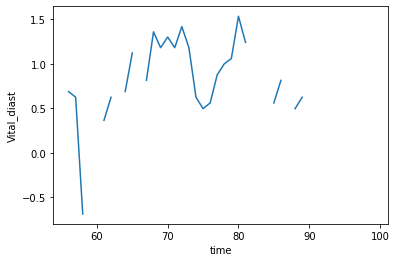

In [6]:
import matplotlib.pyplot as plt

# plot data
train_inputs = train_dl.dataset.inputs
val_inputs = val_dl.dataset.inputs
print("Lens train val:", len(train_inputs), len(val_inputs))


pat_idx = 12
feat_idx = 5

feat_name = feature_names[feat_idx]
#print(model.mean[0, feat_idx])
pat_data = train_inputs[pat_idx][:, feat_idx]
print(pat_data.min())
print(torch.isnan(pat_data).sum())
plt.plot(pat_data)
#plt.title(f"Progression of {feat_name}")
plt.ylabel(feat_name)
plt.xlabel("time")

In [7]:
len(pat_data)

100

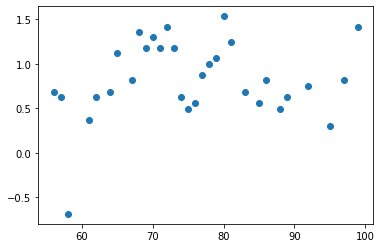

tensor(69)
torch.Size([100])


In [8]:
nan_again = train_inputs[pat_idx][:, feat_idx]
plt.scatter(range(len(nan_again)), nan_again)
plt.show()
print(np.isnan(nan_again).sum())
print(nan_again.shape)

In [9]:
nan_again[0]

tensor(nan, dtype=torch.float64)

In [10]:
nan_again = train_inputs[pat_idx][:, feat_idx].numpy()
pat = torch.from_numpy(nan_again).unsqueeze(1)

use_ema = 1
if use_ema:
    mask_nans = 0
    
    if mask_nans:
        ema_val = 0.4
    else:
        ema_val = 0.90
    # init ema
    ema = pat[0]
    ema[torch.isnan(ema)] = 0
    # run ema
    ema_steps = []
    for pat_step in pat:
        mask = torch.isnan(pat_step)
        if mask_nans:
            ema[~mask] = ema_val * ema[~mask] + (1 - ema_val) * pat_step[~mask]
        else:
            pat_step[mask] = 0
            ema = ema_val * ema + (1 - ema_val) * pat_step
        ema_steps.append(ema.clone())
    pat = torch.stack(ema_steps)
    #print(pat)
else:

    nan_mask = torch.isnan(pat)
    count = (~nan_mask).cumsum(dim=0)
    # calc cumsum without nans
    zero_filled = pat.clone()
    zero_filled[nan_mask] = 0
    cumsum = zero_filled.cumsum(dim=0)
    # calc mean until step:
    mean_until_step = cumsum / count
    # fill mean until step
    #print(pat.shape, nan_mask.shape, self.mean.shape, self.mean.repeat(pat.shape).shape, self.mean.repeat(pat.shape[0], 1))
    pat[nan_mask] = mean_until_step[nan_mask]
    # in some cases we divided by a count of 0, so we have still Nans, fill them with mean
    nan_mask = torch.isnan(pat)
    nan_mask = torch.isnan(pat)
    pat[nan_mask] = 0#self.mean.repeat(pat.shape[0], 1)[nan_mask]

torch.Size([100, 1])
tensor(0., dtype=torch.float64) tensor(0.8908, dtype=torch.float64)
tensor([0.], dtype=torch.float64)


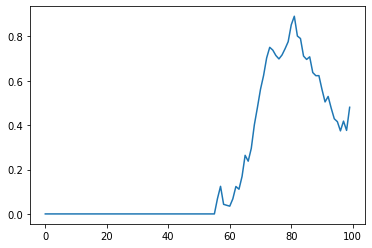

In [11]:
print(pat.shape)
print(pat.min(), pat.max())
print(pat[0])
plt.plot(pat.numpy())

In [13]:
from model import LitRNN, LitTransformer, LitMLP

from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks.model_checkpoint import ModelCheckpoint

# define model
model_type = "mlp"
if model_type == "rnn":
    MyLightingModule = LitRNN  # for loading from checkpoint
    model = LitRNN(feature_names, 
                   hidden_size=args["hidden_size"], 
                   dropout_val=0.2, 
                   lstm_layers=1, 
                   lr=args["lr"],
                   fill_type=args["fill_type"])
elif model_type == "transformer":
    MyLightingModule = LitTransformer  # for loading from checkpoint
    model = LitTransformer(feature_names,
                           ninp=512, # embedding dimension
                           nhead=16, # 2, # num attention heads
                           nhid=1024, #the dimension of the feedforward network model in nn.TransformerEncoder
                           nlayers=8, # the number of heads in the multiheadattention models
                           dropout=0.2,
                           lr=0.00005,
                           fill_type=args["fill_type"])
elif model_type  == "mlp":
    MyLightingModule = LitMLP  # for loading from checkpoint
    model = LitMLP(feature_names, 
                   hidden_size=256, 
                   dropout_val=0.2, 
                   lr=args["lr"],)
#model = torch.jit.script(model)
#model = model.to_torchscript()

Model fill type:  pat_mean


In [14]:
# default logger used by trainer
logger = pl.loggers.mlflow.MLFlowLogger(
    experiment_name='default', 
)
logger.log_hyperparams(args)


es = EarlyStopping(monitor='val_loss_epoch', patience=5, verbose=True, mode="min")
mc = ModelCheckpoint(monitor='val_loss_epoch', verbose=False, save_last=False, save_top_k=1,
                     save_weights_only=False, mode='min', period=None)
callbacks = [mc, es]

trainer = pl.Trainer(
                    callbacks=callbacks,
                    precision=16,
                    max_steps=args["max_steps"],
                    gradient_clip_val=args["grad_clip_val"],
                    track_grad_norm=-1, # -1 to disable
                    truncated_bptt_steps=None, # None to disable, 5 was mentioned in docs
                    logger=logger,
                    weights_summary='top',
                    gpus=1,
                    progress_bar_refresh_rate=1,
                    val_check_interval=100,#args["val_check_interval"],
                    auto_lr_find=False,
    
                    #overfit_batches=1,
                    #limit_val_batches=0.0
) 

Using native 16bit precision.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [15]:
# Run learning rate finder
#lr_finder = trainer.tuner.lr_find(model, train_dl, num_training=100, max_lr=0.1, min_lr=1e-7)#, early_stop_threshold=None)

# Results can be found in
#lr_finder.results

# Plot with
#fig = lr_finder.plot(suggest=True)
#fig.show()

# Pick point based on plot, or get suggestion
#new_lr = lr_finder.suggestion()
#new_lr

In [16]:
# update hparams of the model
#new_lr = 5e-4
#model.hparams.lr = new_lr
#model.lr = new_lr

In [17]:
trainer.fit(model, train_dl, val_dl)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name      | Type           | Params
---------------------------------------------
0 | out_mlp   | Sequential     | 6.9 K 
1 | loss_func | SequentialLoss | 0     
---------------------------------------------
6.9 K     Trainable params
0         Non-trainable params
6.9 K     Total params
0.028     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, val dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
Global seed set to 1
/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/data_loading.py:105: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/plugins/precision/precision_plugin.py:138: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  torch.nn.utils.clip_grad_norm_(parameters, clip_val)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/anton/.local/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


<AxesSubplot:xlabel='step', ylabel='val'>

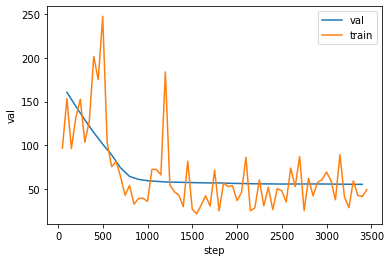

In [20]:
import seaborn as sns

metrics_path = f"./mlruns/1/{logger.run_id}/metrics"
#with open(os.path.join(metrics_path, "val_loss_step"), "r")
train_loss_step = pd.read_csv(os.path.join(metrics_path, "train_loss"), delimiter=" ", header=None, names=["time", "val", "step"])
#pd.read_csv(os.path.join(metrics_path, "train_loss_step"), delimiter=" ", header=None, names=["time", "val", "step"])
val_loss_epoch = pd.read_csv(os.path.join(metrics_path, "val_loss_epoch"), delimiter=" ", header=None, names=["time", "val", "step"])
sns.lineplot(x=val_loss_epoch["step"], y=val_loss_epoch["val"], label="val")
sns.lineplot(x=train_loss_step["step"], y=train_loss_step["val"], label="train")

In [22]:
# load best checkpoint
model = MyLightingModule.load_from_checkpoint(mc.best_model_path, feature_names=feature_names, hidden_size=256)

Model fill type:  pat_mean


In [23]:
# Eval model
all_targets = []
all_preds = []
all_times = []
all_ids = []
all_losses = []
count = 0
model.to("cuda")
model.eval()

dl_type = "val"
if dl_type == "train":
    train_dl.dataset.train = False
    dl = train_dl
else:
    dl = val_dl
    
with torch.no_grad():
    for inputs, targets, lens in dl:
        bs = inputs.shape[0]
        # to gpu
        inputs = inputs.to("cuda")
        targets = targets.to("cuda")
        # pred
        preds = model(inputs)
        # loss
        mask = torch.isnan(targets)
        loss = model.loss_func(preds, targets, mask)
        # other details
        times = torch.stack([torch.arange(inputs.shape[1]) for _ in range(bs)]).unsqueeze(-1)
        ids = torch.stack([torch.ones(inputs.shape[1]) * (count + i) for i in range(bs)]).unsqueeze(-1)
        count += bs
        
        targets = torch.cat([t[:l] for t, l in zip(targets, lens)]).flatten()
        times = torch.cat([t[:l] for t, l in zip(times, lens)]).flatten()
        preds = torch.cat([t[:l] for t, l in zip(preds, lens)]).flatten()
        ids = torch.cat([t[:l] for t, l in zip(ids, lens)]).flatten()
        
        all_targets.append(targets)
        all_preds.append(preds)
        all_times.append(times)
        all_ids.append(ids)
        all_losses.append(loss)
        
all_baseline_losses = torch.stack([(t[~torch.isnan(t)] - mean_train_target).pow(2).mean() for t in all_targets]).cpu().flatten().numpy()

all_losses = torch.stack(all_losses).cpu().flatten().numpy()
all_targets = torch.cat(all_targets).cpu().flatten().numpy()
all_preds = torch.cat(all_preds).cpu().flatten().numpy()
all_ids = torch.cat(all_ids).cpu().flatten().numpy()
all_times = torch.cat(all_times).cpu().flatten().numpy()
all_errors = (all_targets - all_preds) ** 2

df = pd.DataFrame({"targets": all_targets, "preds": all_preds, "ids": all_ids, "step": all_times, "error": all_errors})
by_pat = df.groupby("ids").apply(lambda x: x[~x["targets"].isna()].mean())

In [24]:
import sklearn
print("Mean/Std preds: ", np.mean(all_preds), np.std(all_preds))
print("Mean/Std targets: ", np.mean(df["targets"]), np.std(df["targets"]))
print("Max error: ", np.max(df["error"]))
print("Mean error: ", np.mean(df["error"]))
print("By Pat Mean error: ", np.mean(by_pat["error"]))
print()

mask = df["targets"].isna()
non_na_targets = df["targets"][~mask]
non_na_preds = df["preds"][~mask]
r2_model = sklearn.metrics.r2_score(non_na_targets, non_na_preds)
explained_var = sklearn.metrics.explained_variance_score(non_na_targets, non_na_preds)
print("Mean model loss: ", np.mean(all_losses))
print("Model R2 score: ", round(r2_model, 2))
print("Explained var: ", explained_var)
print()

r2_mean = sklearn.metrics.r2_score(non_na_targets, [df["targets"].mean()] * len(non_na_targets))
print("Mean baseline loss: ", np.mean(all_baseline_losses))
print("Mean baseline R2 score: ", round(r2_mean, 2))

Mean/Std preds:  10.505914 2.71693
Mean/Std targets:  10.432425 5.914493
Max error:  924.59863
Mean error:  33.036835
By Pat Mean error:  55.19995026983494

Mean model loss:  55.444424
Model R2 score:  0.06
Explained var:  0.055658698081970215

Mean baseline loss:  39.39933
Mean baseline R2 score:  0.0


In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
mean_pred_error = (df["targets"] - mean_train_target).dropna() ** 2
mean_pred_error
df["mean_pred_error"] = mean_pred_error
df["mean_pred"] = mean_train_target

(0.0, 800.0)

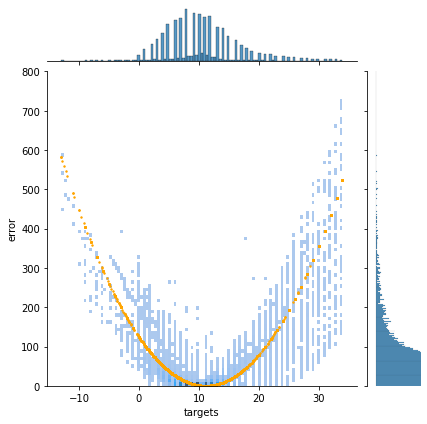

In [27]:
ax = sns.jointplot(x="targets", y="error", data=df, kind="hist", bins=100) # data=by_pat
ax.ax_joint.scatter(df["targets"].dropna(), mean_pred_error, s=2, color="orange")
plt.xlim(-20, 105)
plt.ylim(0, 800)

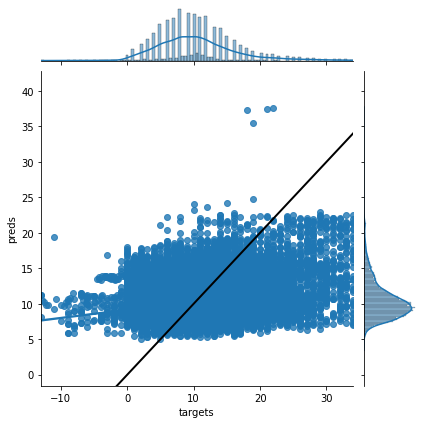

In [28]:
ylim = (df["preds"].min() - 5, df["preds"].max() + 5)
ax = sns.jointplot(data=df, x="targets", y="preds", kind="reg", ylim=ylim) # data=bypat
min_val = df["targets"].min()
max_val = df["targets"].max()
ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2, color="black")

-13.0 34.0


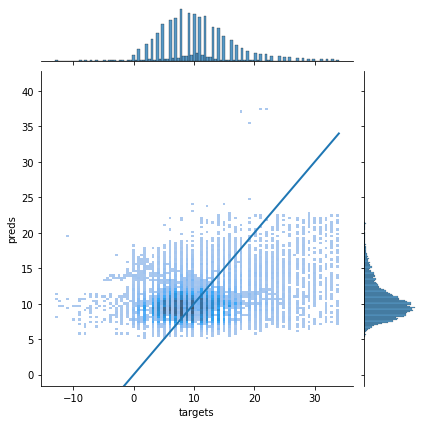

In [29]:
ax = sns.jointplot(data=df, x="targets", y="preds", kind="hist", bins=100, ylim=ylim)
print(min_val, max_val)
# draw line of perfect correlation
ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")

In [30]:
df["preds"].describe()

count    42311.000000
mean        10.505914
std          2.716962
min          3.434138
25%          8.677688
50%          9.954914
75%         11.636683
max         37.743683
Name: preds, dtype: float64

In [31]:
# takes too long 
#ax = sns.jointplot(data=df, x="targets", y="preds", kind="kde")
#ax.ax_joint.plot([min_val, max_val], [min_val, max_val], linewidth=2)#, color="black")

In [32]:
count = 0

In [33]:
#pats = df.groupby("ids").filter(lambda x: x['preds'].max() > 10)
pats = df.groupby("ids").filter(lambda x: x['targets'].max() > 30)
#pats = df.groupby("ids").filter(lambda x: x['error'].mean() > 50)

ids = pats["ids"].unique()
print(ids)
print(len(ids), "patients")
#pats

[  0.   1.  14.  19.  26.  33.  53.  57.  60.  67.  74.  79.  80.  83.
  84.  88.  91.  96. 107. 114. 120. 125. 133. 139. 145. 149. 152. 153.
 161. 162. 163. 164. 166. 167.]
34 patients


In [34]:
def rmse(targets, preds):
    return np.sqrt(np.mean((targets - preds) ** 2))

mean average target:  10.432425
mean pat targets:  15.955556
RMSE of model: 12.48532
RMSE of mean: 11.903907


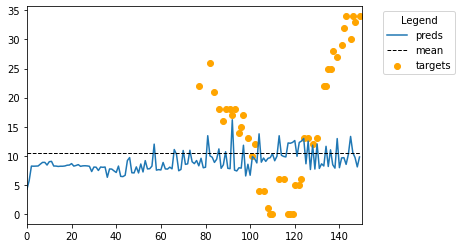

In [44]:
pat_id = 8

pat = df[df["ids"] == ids[pat_id]]
plt.scatter(pat["step"], pat["targets"], label="targets", color="orange")
plt.plot(pat["step"], pat["preds"], label="preds")
mean = df["targets"].mean()
print("mean average target: ", mean)
print("mean pat targets: ", pat["targets"].mean())
plt.plot([0, max(pat["step"])], [mean, mean], linewidth=1, color="black", label="mean", linestyle="--")
#plt.legend(location="out")
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim(0, max(pat["step"]) + 1)
print("RMSE of model:", rmse(pat["targets"], pat["preds"]))
print("RMSE of mean:", rmse(pat["targets"], mean))

In [45]:
len(df["ids"].unique())

172

172
torch.Size([34])


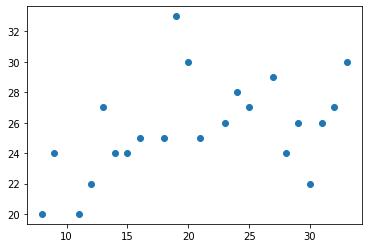

tensor(12)
torch.Size([34])


In [46]:
print(len(val_dl.dataset.targets))
nan_again = val_dl.dataset.targets[0]
print(nan_again.shape)
plt.scatter(range(len(nan_again)), nan_again)
plt.show()
print(np.isnan(nan_again).sum())
print(nan_again.shape)

In [47]:
def make_iter(dl):
    for i in range(len(dl.dataset.inputs)):
        yield dl.dataset[i]

count = 0
for i in make_iter(val_dl):
    count += 1
count

172

In [48]:
count = 0
for i in range(len(val_dl.dataset.targets)):
    count += 1
count

172

In [49]:
count = 0
length = 0
for i in iter(val_dl):
    length = len(i)
    count += 1
print(length)
print(count)

3
22


In [50]:
val_dl.batch_size

8

In [51]:
mask = ~pat["targets"].isna()
(pat["targets"][mask] - pat["preds"][mask]).pow(2).mean()

155.88321

In [52]:
(pat["targets"] - pat["preds"]).pow(2).mean()

155.88321

In [53]:
per_step = df.groupby("step").mean()

<AxesSubplot:xlabel='step'>

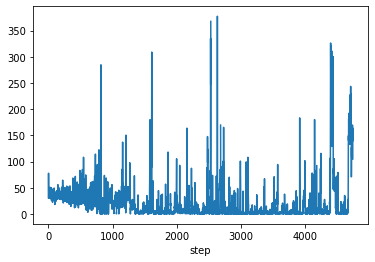

In [54]:
per_step["error"].plot()

In [55]:
import matplotlib.pyplot as plt

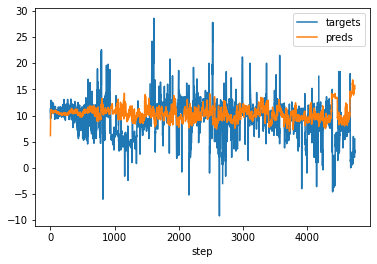

In [56]:
per_step["targets"].plot()
per_step["preds"].plot()
plt.legend()

<AxesSubplot:xlabel='ids', ylabel='error'>

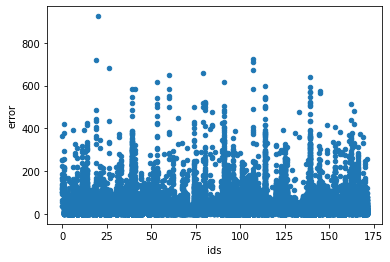

In [57]:
df.plot.scatter("ids", "error")

<AxesSubplot:xlabel='step', ylabel='error'>

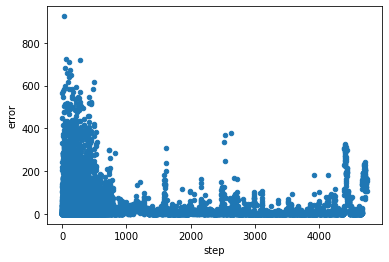

In [58]:
df.plot.scatter("step", "error")

## Saliency

In [59]:
from captum.attr import NoiseTunnel, Saliency

class LSTMLastStep(torch.nn.Module):
    def __init__(self, net):
        super(LSTMLastStep, self).__init__()
        self.net = net

    def forward(self, x):
        out = self.net(x)
        # take last timestep
        out = out[:, -1, :]
        return out


class LSTMSelectFeature(torch.nn.Module):
    def __init__(self, net, idx):
        super().__init__()
        self.net = net
        self.idx = idx
    
    def forward(self, x):
        out = self.net(x)
        if self.idx is not None:
            out = out[:, self.idx]
            out = out.unsqueeze(1)
        return out


def get_sal_model(model, idx=None):
    saliency = Saliency(LSTMSelectFeature(LSTMLastStep(model), idx))
    noise_tunnel = NoiseTunnel(saliency)
    return noise_tunnel

sal_model = get_sal_model(model)

In [60]:
def get_all_attrs(model, absolute=False, target_idx=None, desired_target_val=None, perc=None, agg=True, ds=None, tqdm_off=True):
    if ds is None:
        ds = model.val_dataloader().dataset
    ids = range(len(ds.inputs))
    if perc is not None:
        ids = ids[:int(len(ids) * perc)]
        print("Only processing ", len(ids), " ids")
        
    model.train()
    attrs = []
    for pat_id in tqdm(ids, disable=tqdm_off):
        attr = get_attr_single(model, pat_id, absolute=absolute, target_idx=target_idx, desired_target_val=desired_target_val, ds=ds)
        if len(attr) > 0:
            attrs.append(attr)
    if agg:
        attrs = utils.pad_and_mask(attrs)
    return attrs


def get_attr_single(model, pat_id, absolute=False, tqdm_off=True, target_idx=None, desired_target_val=None, ds=None):
    if ds is None:
        ds = model.val_dataloader().dataset
    # pat_data, pat_target, idx, len_ = ds[pat_id]
    pat_data, pat_target = ds[pat_id]
    if target_idx is None:
        target_idx = 0
    model = get_sal_model(model, target_idx)
    attrs = []
    #print("Pat data shape: ", pat_data.shape)
    for end_idx in tqdm(range(1, len(pat_data) + 1), disable=tqdm_off):
        if desired_target_val is not None and pat_target[end_idx - 1, target_idx] != desired_target_val:
            # if the target is not the desired value, then don't calculate the saliency for it
            continue
        data = pat_data[:end_idx].unsqueeze(0).cuda()
        if len(data.shape) == 4:
            data = data.squeeze(0)
        data.requires_grad = True
        attr = model.attribute(data, nt_type="smoothgrad", nt_samples=50,
                               stdevs=0.01, abs=absolute).detach().cpu().squeeze(0)
        data.requires_grad = False
        attr /= attr.abs().sum()
        attr = attr.unsqueeze(0)
        # print('ATTR', attr.shape)
        attrs.append(attr)
    if len(attrs) > 0:
        attrs = pad_and_mask(attrs)
    else:
        attrs = np.zeros(0)

    # Divide each timestep by number of times that saliency was computed for it
    #inv_count = np.arange(1, len(pat_data) + 1)[::-1]
    #print(inv_count.shape)
    #attrs = attrs / inv_count
    return attrs


def get_sal_list(model, idx, perc, agg, ds=None):
    attrs = get_all_attrs(model, target_idx=idx, perc=perc, agg=False, ds=ds, tqdm_off=False)
    summed_per_pat = [attr.sum(axis=0) for attr in attrs]
    return summed_per_pat

def pad_and_mask(data, mask_value=math.nan):
    # find max seq len
    max_len = max([pat.shape[1] for pat in data])
    # pad each seq to max seq len
    data = [np.concatenate([pat, np.zeros([pat.shape[0], max_len - pat.shape[1], pat.shape[2]]) * math.nan], axis=1) for pat in data]
    # concat all seqs
    data = np.concatenate(data)
    #data = torch.nn.utils.rnn.pad_sequence(data, batch_first=True, padding_value=mask_value)
    if math.isnan(mask_value):
        mask = np.isnan(data)
    else:
        mask = data == mask_value
    data = np.ma.masked_array(data, mask=mask)
    return data

In [61]:
sal_list = get_sal_list(model, 0, perc=0.1, agg=True, ds=val_dl.dataset)


  0%|                                                         | 0/17 [00:00<?, ?it/s]

Only processing  17  ids



100%|████████████████████████████████████████████████| 17/17 [00:06<00:00,  2.64it/s]


In [62]:
mean_overall = [s.mean(0) for s in sal_list]
feat_saliency = np.sum(mean_overall, axis=0)

In [63]:
feat_sal_df = pd.DataFrame({"sal": feat_saliency}, index = feature_names).sort_values("sal")

<AxesSubplot:>

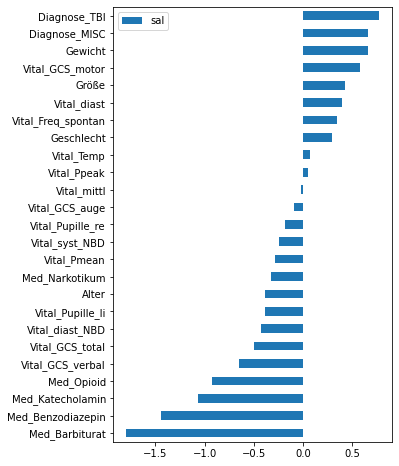

In [64]:
feat_sal_df.plot.barh(figsize = (5, 8))

In [ ]:
feat_sal_df.plot.barh(figsize = (5, 8))

In [ ]:
feat_sal_df.plot.barh(figsize = (5, 8))